<a href="https://colab.research.google.com/github/AlyssonBatista/TCC-engenharia-eletrica-codigos-polares/blob/main/C%C3%B3digos_polares_com_modula%C3%A7%C3%A3o_de_ordem_superior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU Configuration and Imports

In [4]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Load the required Sionna components
from sionna.mapping import Constellation, Mapper, Demapper
from sionna.fec.polar import PolarEncoder, Polar5GEncoder, PolarSCLDecoder, Polar5GDecoder, PolarSCDecoder
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.fec.polar.utils import generate_5g_ranking, generate_rm_code
from sionna.fec.conv import ConvEncoder, ViterbiDecoder, BCJRDecoder
from sionna.fec.turbo import TurboEncoder, TurboDecoder
from sionna.fec.linear import OSDecoder
from sionna.utils import BinarySource, ebnodb2no
from sionna.utils.metrics import  count_block_errors
from sionna.channel import AWGN
from sionna.utils.plotting import PlotBER

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time # for throughput measurements

In [6]:
import tensorflow as tf
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

In [7]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Import TensorFlow and NumPy
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
import numpy as np

# For plotting
%matplotlib inline
import matplotlib.pyplot as plt

# For saving complex Python data structures efficiently
import pickle

# For the implementation of the neural receiver
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Layer

# Código polar 5G

## Gerando um código polar

In [300]:
code_type = "5G" # try also "RM"

# Load the 5G compliant polar code
if code_type=="5G":
    k = 32
    n = 64
    # load 5G compliant channel ranking [3]
    frozen_pos, info_pos = generate_5g_ranking(k,n)
    print("Generated Polar code of length n = {} and k = {}".format(n, k))
    print("Frozen codeword positions: ", frozen_pos)



Generated Polar code of length n = 64 and k = 32
Frozen codeword positions:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 24 25 26
 32 33 34 35 36 37 40 48]


In [301]:
# init polar encoder
encoder_polar = PolarEncoder(frozen_pos, n)

# init binary source to generate information bits
source = BinarySource()
# define a batch_size
batch_size = 1

# generate random info bits
u = source([batch_size, k])
# and encode
c = encoder_polar(u)

print("Information bits: ", u.numpy())
print("Polar encoded bits: ", c.numpy())

Information bits:  [[0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0.
  1. 1. 0. 1. 1. 1. 0. 1.]]
Polar encoded bits:  [[1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0.
  0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1.]]


# Configurando um modelo de sistema para simulações de BER com codificação de canal.

In [148]:
class System_Model(tf.keras.Model):
    """Modelo de sistema para simulações de BER com codificação de canal.

    Este modelo permite simular BERs em um canal AWGN com modulação QAM.
    Camadas arbitrárias de codificação/decodificação FEC podem ser usadas
    para inicializar o modelo.

    Parâmetros
    ----------
        k: int
            número de bits de informação por palavra-código.

        n: int
            comprimento da palavra-código.

        num_bits_per_symbol: int
            número de bits por símbolo QAM.

        encoder: camada Keras
            Uma camada Keras que codifica tensores de bits de informação.

        decoder: camada Keras
            Uma camada Keras que decodifica tensores LLR.

        demapping_method: str
            Uma string que denota o método de demapeamento. Pode ser "app" ou "maxlog".

        sim_esno: bool
            Um booleano que, por padrão, é False. Se for True, nenhum ajuste de taxa é feito para o cálculo da SNR.

        cw_estimates: bool
            Um booleano que, por padrão, é False. Se for True, estimativas de palavras-código em vez de estimativas de informação são retornadas.

    Entrada
    ------
        batch_size: int ou tf.int
            O tamanho do lote usado para a simulação.

        ebno_db: float ou tf.float
            Um float que define a SNR da simulação.

    Saída
    ------
        (u, u_hat):
            Tupla:

        u: tf.float32
            Um tensor de forma `[batch_size, k]` contendo 0s e 1s com os bits de informação transmitidos.

        u_hat: tf.float32
            Um tensor de forma `[batch_size, k]` contendo 0s e 1s com os bits de informação estimados.
    """

    def __init__(self,
                 k,
                 n,
                 num_bits_per_symbol,
                 encoder,
                 decoder,
                 demapping_method="app",
                 sim_esno=False,
                 cw_estimates=False):

        super().__init__()

        # armazena os valores internamente
        self.k = k
        self.n = n
        self.sim_esno = sim_esno  # desativa o ajuste de taxa para o cálculo da SNR
        self.cw_estimates = cw_estimates  # se verdadeiro, retorna palavras-código em vez de bits de informação

        # número de bits por símbolo QAM
        self.num_bits_per_symbol = num_bits_per_symbol

        # inicializa componentes
        self.source = BinarySource()
        # inicializa mapeador e desmapeador para o objeto de constelação
        self.constellation = Constellation("qam",
                                num_bits_per_symbol=self.num_bits_per_symbol)
        self.mapper = Mapper(constellation=self.constellation)
        self.demapper = Demapper(demapping_method,
                                 constellation=self.constellation)

        # o canal pode ser substituído por modelos mais sofisticados
        self.channel = AWGN()

        # Codificador/decodificador FEC
        self.encoder = encoder
        self.decoder = decoder

    @tf.function()  # habilita o modo gráfico para aumentar o desempenho
    def call(self, batch_size, ebno_db):

        # calcula a variância do ruído
        if self.sim_esno:
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=1,
                           coderate=1)
        else:
            no = ebnodb2no(ebno_db,
                           num_bits_per_symbol=self.num_bits_per_symbol,
                           coderate=self.k/self.n)

        u = self.source([batch_size, self.k])  # gera dados aleatórios
        c = self.encoder(u)  # codifica explicitamente

        x = self.mapper(c)  # mapeia c para símbolos x

        y = self.channel([x, no])  # transmite pelo canal AWGN

        llr_ch = self.demapper([y, no])  # desmapeia y para LLRs

        u_hat = self.decoder(llr_ch)  # executa o decodificador FEC (incluindo recuperação de taxa)

        if self.cw_estimates:
            return c, u_hat

        return u, u_hat, x, y


# Desempenho de códigos Polares com palavras códigos N=128 e K=64 para cada modulação analisada e seus respectivos diagramas de constelação.

## QPSK (4-QAM): 2 bits por símbolo

In [302]:
# init new figure
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 4-QAM")

In [303]:
# code parameters to simulate
ns = [128]  # number of codeword bits per codeword
rate = 0.5 # fixed coderate

# create list of encoder/decoder pairs to be analyzed
codes_under_test = []

# 5G LDPC codes
for n in ns:
    k = int(rate*n) # calculate k for given n and rate
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name =f"Código polar SC (N={n} K={k}), modulação 4-QAM"
    codes_under_test.append([enc, dec, name, k, n])


Running: Código polar SC (N=128 K=64), modulação 4-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.1152e-01 | 9.5600e-01 |       26337 |       64000 |          956 |        1000 |        11.2 |reached target block errors
      0.5 | 3.5777e-01 | 8.8600e-01 |       22897 |       64000 |          886 |        1000 |         0.1 |reached target block errors
      1.0 | 3.1227e-01 | 8.0900e-01 |       19985 |       64000 |          809 |        1000 |         0.1 |reached target block errors
      1.5 | 2.4713e-01 | 6.5300e-01 |       15816 |       64000 |          653 |        1000 |         0.1 |reached target block errors
      2.0 | 1.6830e-01 | 4.6500e-01 |       21543 |      128000 |          930 |        2000 |         0.1 |reached target block errors
      2.5 

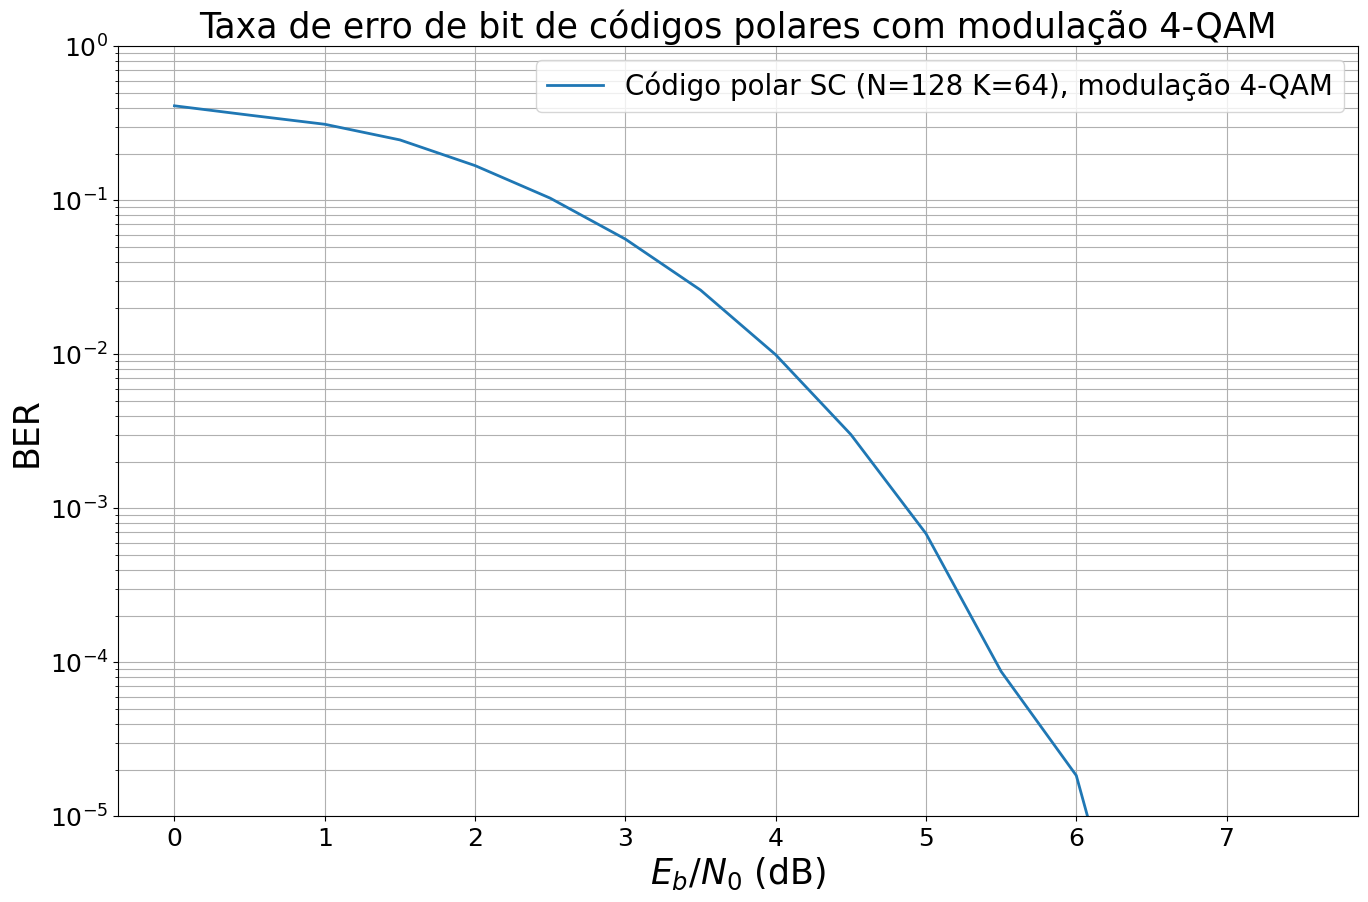

In [304]:
# and simulate the results
num_bits_per_symbol = 2 # QPSK

ebno_db = np.arange(0, 10, 0.5) # sim SNR range
# note that the waterfall for long codes can be steep and requires a fine
# SNR quantization

# run ber simulations for each case
for code in codes_under_test:
    print("Running: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # the first argument must be a callable (function) that yields u and u_hat
    # for given batch_size and ebno
    # we fix the target number of BLOCK errors instead of the BER to
    # ensure that same accurate results for each block lengths is simulated
    ber_plot_Polar.simulate(model, # the function have defined previously
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # we fix the target block errors
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # should be True in a loop

# and show figure
ber_plot_Polar(ylim=(1e-5, 1))

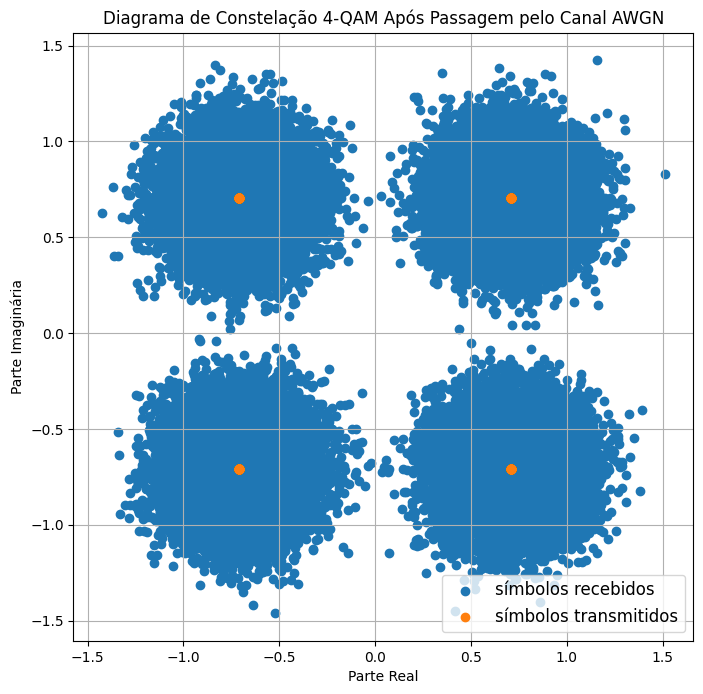

<Figure size 640x480 with 0 Axes>

In [305]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Diagrama de Constelação 4-QAM Após Passagem pelo Canal AWGN')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.scatter(tf.math.real(model.call(1000,12)[3]), tf.math.imag(model.call(1000,12)[3]), label='símbolos recebidos')
plt.scatter(tf.math.real(model.call(1000,12)[2]), tf.math.imag(model.call(1000,12)[2]), label='símbolos transmitidos')
plt.legend(fontsize=12, loc='lower right')  # Ajuste os valores de bbox_to_anchor conforme necessário
plt.show()
plt.tight_layout()

## 16-QAM: 4 bits por símbolo

In [306]:
# init new figure
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 16-QAM")

In [307]:
# code parameters to simulate
ns = [128]  # number of codeword bits per codeword
rate = 0.5 # fixed coderate

# create list of encoder/decoder pairs to be analyzed
codes_under_test = []

# 5G LDPC codes
for n in ns:
    k = int(rate*n) # calculate k for given n and rate
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name =f"Código polar SC (N={n}), modulação 16-QAM"
    codes_under_test.append([enc, dec, name, k, n])


Running: Código polar SC (N=128), modulação 16-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.7714e-01 | 1.0000e+00 |       30537 |       64000 |         1000 |        1000 |        10.3 |reached target block errors
      0.5 | 4.6772e-01 | 9.9500e-01 |       29934 |       64000 |          995 |        1000 |         0.1 |reached target block errors
      1.0 | 4.5634e-01 | 9.9400e-01 |       29206 |       64000 |          994 |        1000 |         0.1 |reached target block errors
      1.5 | 4.3650e-01 | 9.8600e-01 |       27936 |       64000 |          986 |        1000 |         0.1 |reached target block errors
      2.0 | 4.2203e-01 | 9.7100e-01 |       27010 |       64000 |          971 |        1000 |         0.1 |reached target block errors
      2.5 | 3.

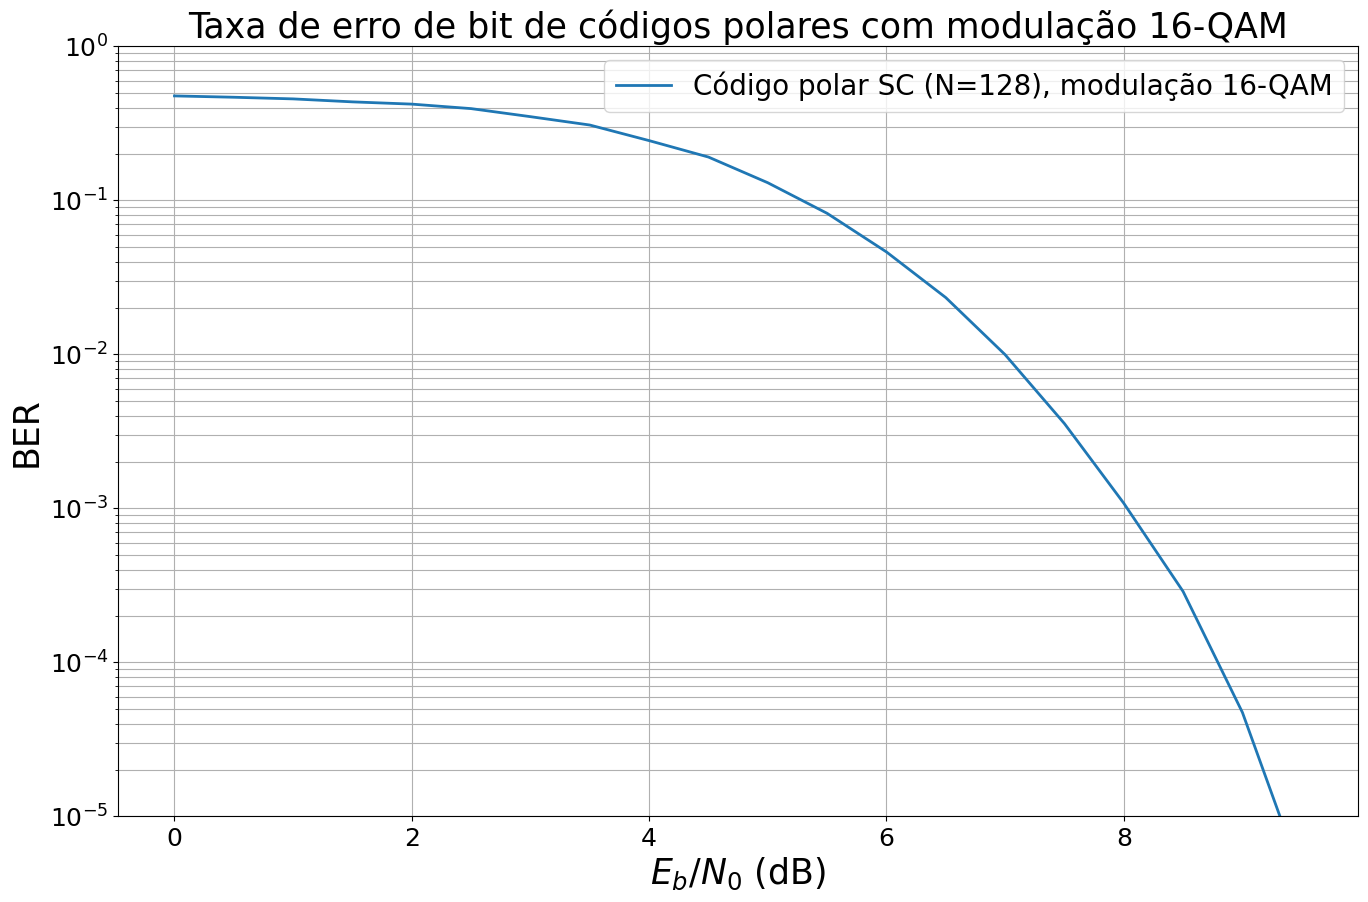

In [308]:
# and simulate the results
num_bits_per_symbol = 4 # 16-QAM

ebno_db = np.arange(0, 10, 0.5) # sim SNR range
# note that the waterfall for long codes can be steep and requires a fine
# SNR quantization

# run ber simulations for each case
for code in codes_under_test:
    print("Running: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # the first argument must be a callable (function) that yields u and u_hat
    # for given batch_size and ebno
    # we fix the target number of BLOCK errors instead of the BER to
    # ensure that same accurate results for each block lengths is simulated
    ber_plot_Polar.simulate(model, # the function have defined previously
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # we fix the target block errors
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # should be True in a loop

# and show figure
ber_plot_Polar(ylim=(1e-5, 1))

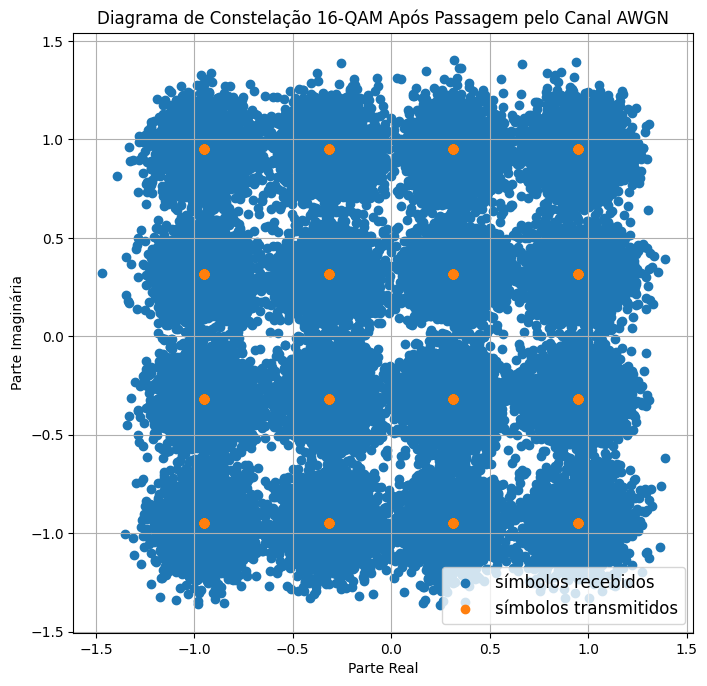

<Figure size 640x480 with 0 Axes>

In [309]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Diagrama de Constelação 16-QAM Após Passagem pelo Canal AWGN')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.scatter(tf.math.real(model.call(1000,12)[3]), tf.math.imag(model.call(1000,12)[3]), label='símbolos recebidos')
plt.scatter(tf.math.real(model.call(1000,12)[2]), tf.math.imag(model.call(1000,12)[2]), label='símbolos transmitidos')
plt.legend(fontsize=12, loc='lower right')  # Ajuste os valores de bbox_to_anchor conforme necessário
plt.show()
plt.tight_layout()

## 256-QAM: 8 bits por símbolo

In [310]:
# init new figure
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 256-QAM")

In [311]:
# code parameters to simulate
ns = [128]  # number of codeword bits per codeword
rate = 0.5 # fixed coderate

# create list of encoder/decoder pairs to be analyzed
codes_under_test = []

# 5G LDPC codes
for n in ns:
    k = int(rate*n) # calculate k for given n and rate
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name =f"Código polar SC (N={n}), modulação 256-QAM"
    codes_under_test.append([enc, dec, name, k, n])

Running: Código polar SC (N=128), modulação 256-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.8845e-01 | 1.0000e+00 |       31261 |       64000 |         1000 |        1000 |        12.8 |reached target block errors
      0.5 | 4.8287e-01 | 1.0000e+00 |       30904 |       64000 |         1000 |        1000 |         0.9 |reached target block errors
      1.0 | 4.8680e-01 | 1.0000e+00 |       31155 |       64000 |         1000 |        1000 |         0.9 |reached target block errors
      1.5 | 4.8230e-01 | 1.0000e+00 |       30867 |       64000 |         1000 |        1000 |         0.8 |reached target block errors
      2.0 | 4.8227e-01 | 1.0000e+00 |       30865 |       64000 |         1000 |        1000 |         0.9 |reached target block errors
      2.5 | 4

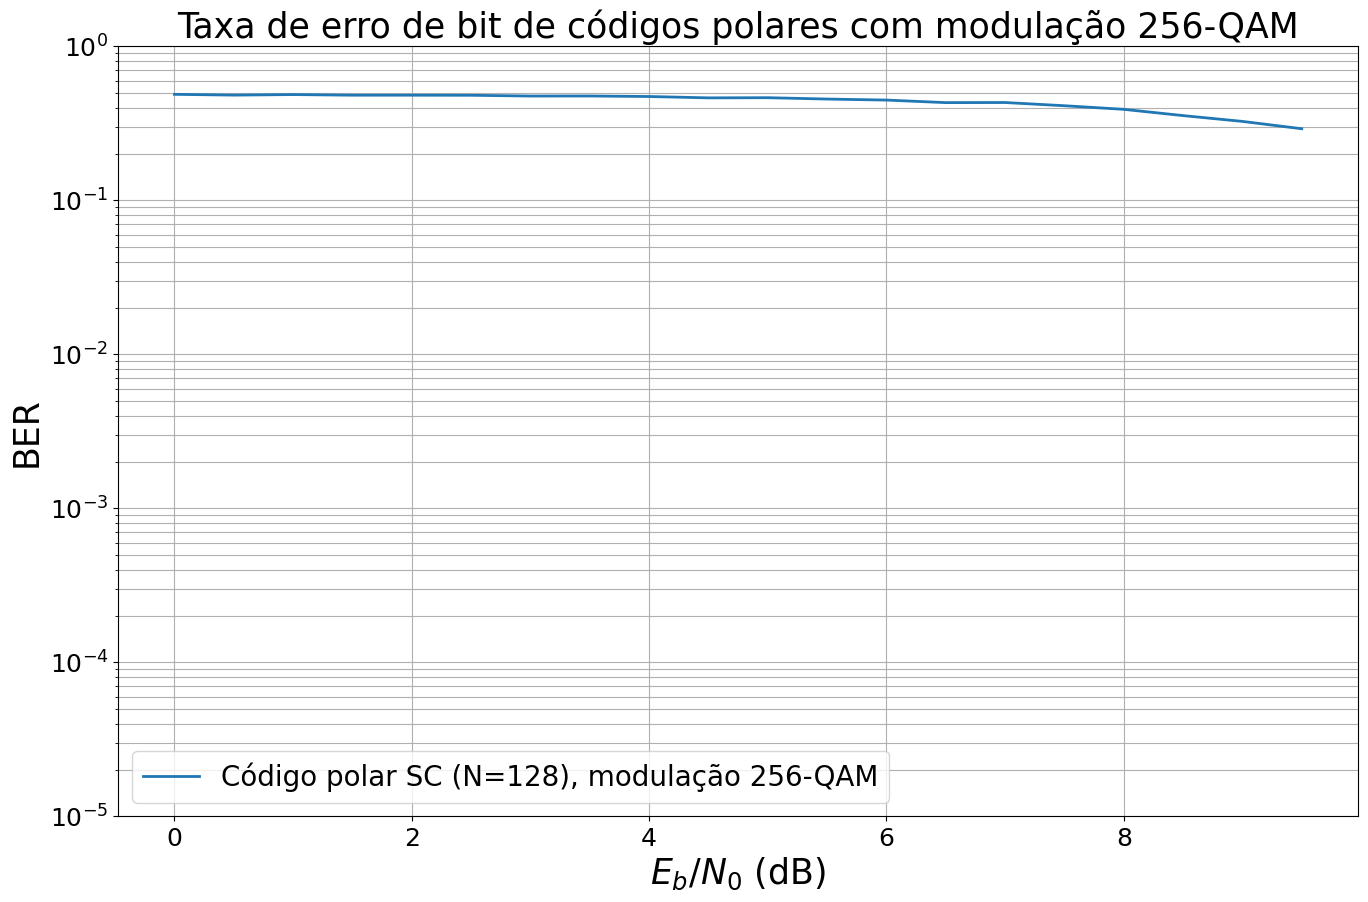

In [312]:
# and simulate the results
num_bits_per_symbol = 8 # 256-QAM

ebno_db = np.arange(0, 10, 0.5) # sim SNR range
# note that the waterfall for long codes can be steep and requires a fine
# SNR quantization

# run ber simulations for each case
for code in codes_under_test:
    print("Running: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # the first argument must be a callable (function) that yields u and u_hat
    # for given batch_size and ebno
    # we fix the target number of BLOCK errors instead of the BER to
    # ensure that same accurate results for each block lengths is simulated
    ber_plot_Polar.simulate(model, # the function have defined previously
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # we fix the target block errors
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # should be True in a loop

# and show figure
ber_plot_Polar(ylim=(1e-5, 1))

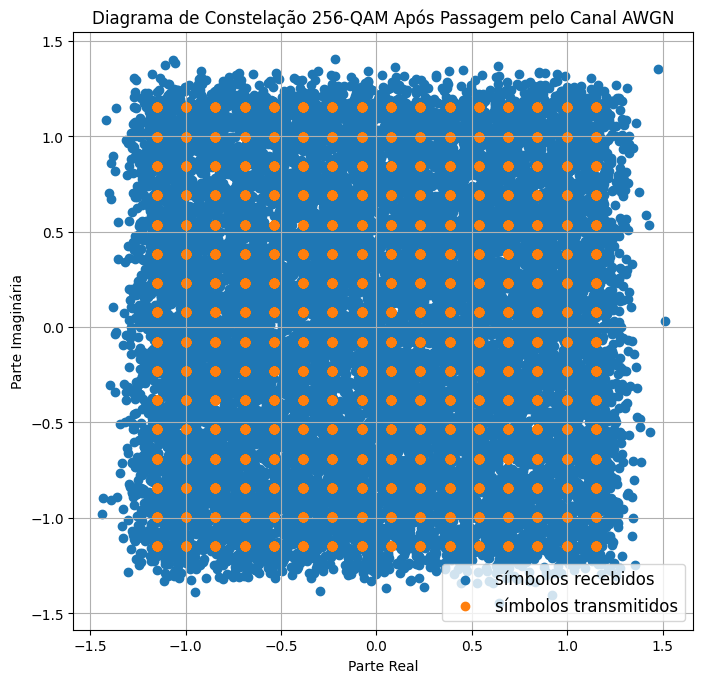

<Figure size 640x480 with 0 Axes>

In [313]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Diagrama de Constelação 256-QAM Após Passagem pelo Canal AWGN')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginária')
plt.scatter(tf.math.real(model.call(1000,12)[3]), tf.math.imag(model.call(1000,12)[3]), label='símbolos recebidos')
plt.scatter(tf.math.real(model.call(1000,12)[2]), tf.math.imag(model.call(1000,12)[2]), label='símbolos transmitidos')
plt.legend(fontsize=12, loc='lower right')  # Ajuste os valores de bbox_to_anchor conforme necessário
plt.show()
plt.tight_layout()


# Desempenho de códigos Polares mais longos utilizando modulação de ordem superior

## QPSK (4-QAM): 2 bits por símbolo

In [314]:
# Inicia uma nova figura
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 4-QAM")

In [315]:
# parâmetros do código para simulação
ns = [64,128,256,512,1024]  # número de bits por palavra-código
rate = 0.5 # taxa de código fixa

# criar lista de pares codificador/decodificador a serem analisados
codes_under_test = []

# códigos Polares 5G
for n in ns:
    k = int(rate*n) # calcular k para o dado n e taxa
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name = f"Código polar SC (N={n} K={k}), modulação 4-QAM"
    codes_under_test.append([enc, dec, name, k, n])


Executando: Código polar SC (N=64 K=32), modulação 4-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.0556e-01 | 9.4300e-01 |       12978 |       32000 |          943 |        1000 |         6.3 |reached target block errors
      0.5 | 3.7125e-01 | 9.0100e-01 |       11880 |       32000 |          901 |        1000 |         0.0 |reached target block errors
      1.0 | 3.2700e-01 | 8.2800e-01 |       10464 |       32000 |          828 |        1000 |         0.0 |reached target block errors
      1.5 | 2.7553e-01 | 7.3300e-01 |        8817 |       32000 |          733 |        1000 |         0.0 |reached target block errors
      2.0 | 2.1731e-01 | 5.9900e-01 |        6954 |       32000 |          599 |        1000 |         0.0 |reached target block errors
      2.

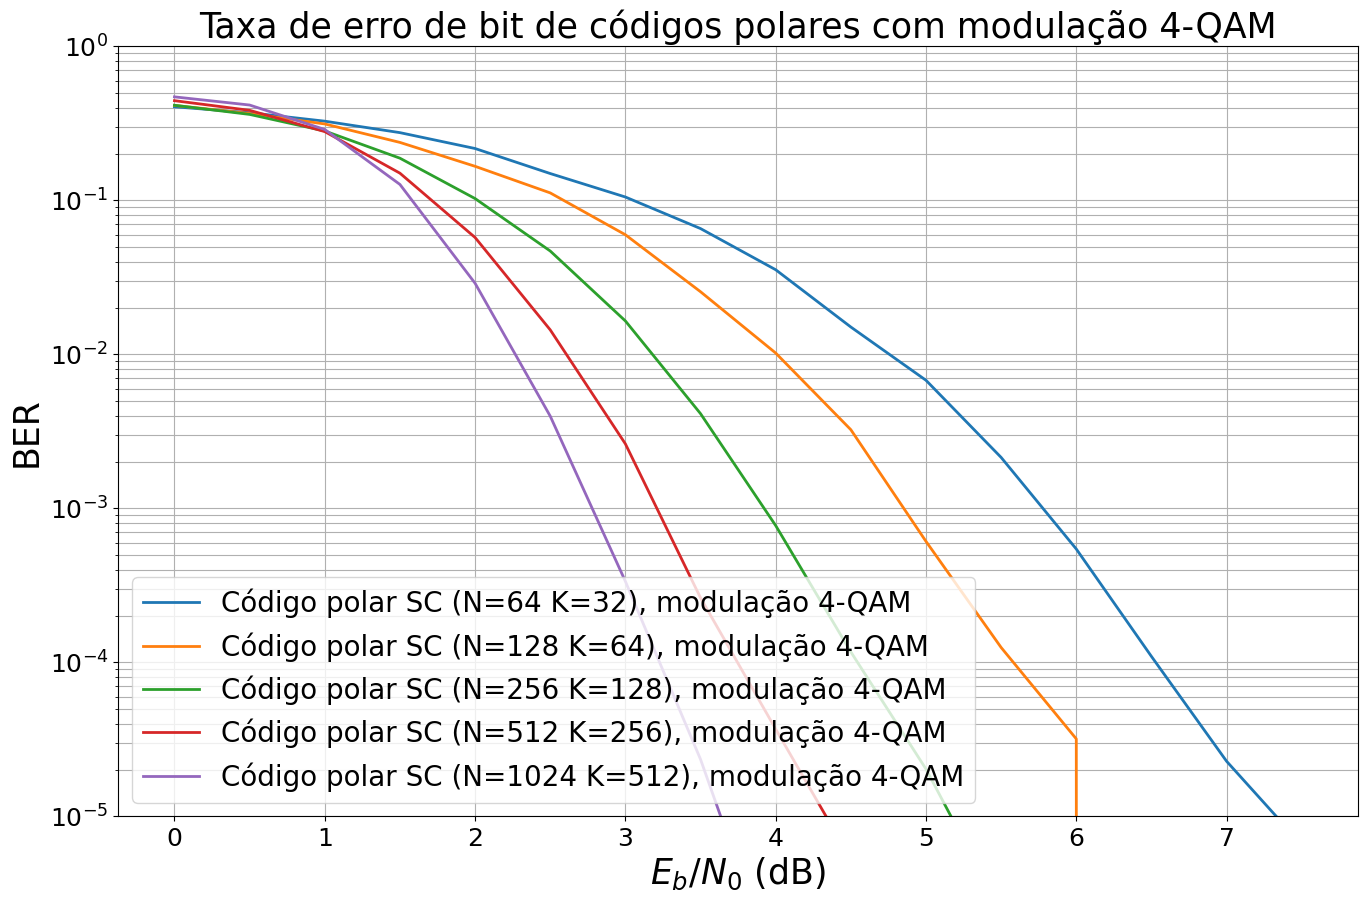

In [316]:
# e simular os resultados
num_bits_per_symbol = 2 # QPSK = 4-QAM

ebno_db = np.arange(0, 11, 0.5) # intervalo de SNR para simulação
# note que a curva de queda para códigos longos pode ser íngreme e requer uma quantização fina de SNR

# executar simulações de BER para cada caso
for code in codes_under_test:
    print("Executando: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # o primeiro argumento deve ser uma função que gera u e u_hat
    # para um dado batch_size e ebno
    # fixamos o número alvo de erros de BLOCO em vez do BER para
    # garantir que os mesmos resultados precisos para cada comprimento de bloco sejam simulados
    ber_plot_Polar.simulate(model, # a função definida anteriormente
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # fixamos os erros de bloco alvo
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # deve ser True em um loop

# e mostrar a figura
ber_plot_Polar(ylim=(1e-5, 1))

## 16-QAM: 4 bits por símbolo

In [317]:
# Inicia uma nova figura
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 16-QAM")

In [318]:
# parâmetros do código para simulação
ns = [64,128,256,512,1024]  # número de bits por palavra-código
rate = 0.5 # taxa de código fixa

# criar lista de pares codificador/decodificador a serem analisados
codes_under_test = []

# códigos Polares 5G
for n in ns:
    k = int(rate*n) # calcular k para o dado n e taxa
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name = f"Código polar SC (N={n} K={k}), modulação 16-QAM"
    codes_under_test.append([enc, dec, name, k, n])

Executando: Código polar SC (N=64 K=32), modulação 16-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.4397e-01 | 9.9500e-01 |       14207 |       32000 |          995 |        1000 |         5.4 |reached target block errors
      0.5 | 4.2422e-01 | 9.9100e-01 |       13575 |       32000 |          991 |        1000 |         0.1 |reached target block errors
      1.0 | 4.1613e-01 | 9.8900e-01 |       13316 |       32000 |          989 |        1000 |         0.1 |reached target block errors
      1.5 | 4.0319e-01 | 9.8300e-01 |       12902 |       32000 |          983 |        1000 |         0.1 |reached target block errors
      2.0 | 3.8894e-01 | 9.5900e-01 |       12446 |       32000 |          959 |        1000 |         0.1 |reached target block errors
      2

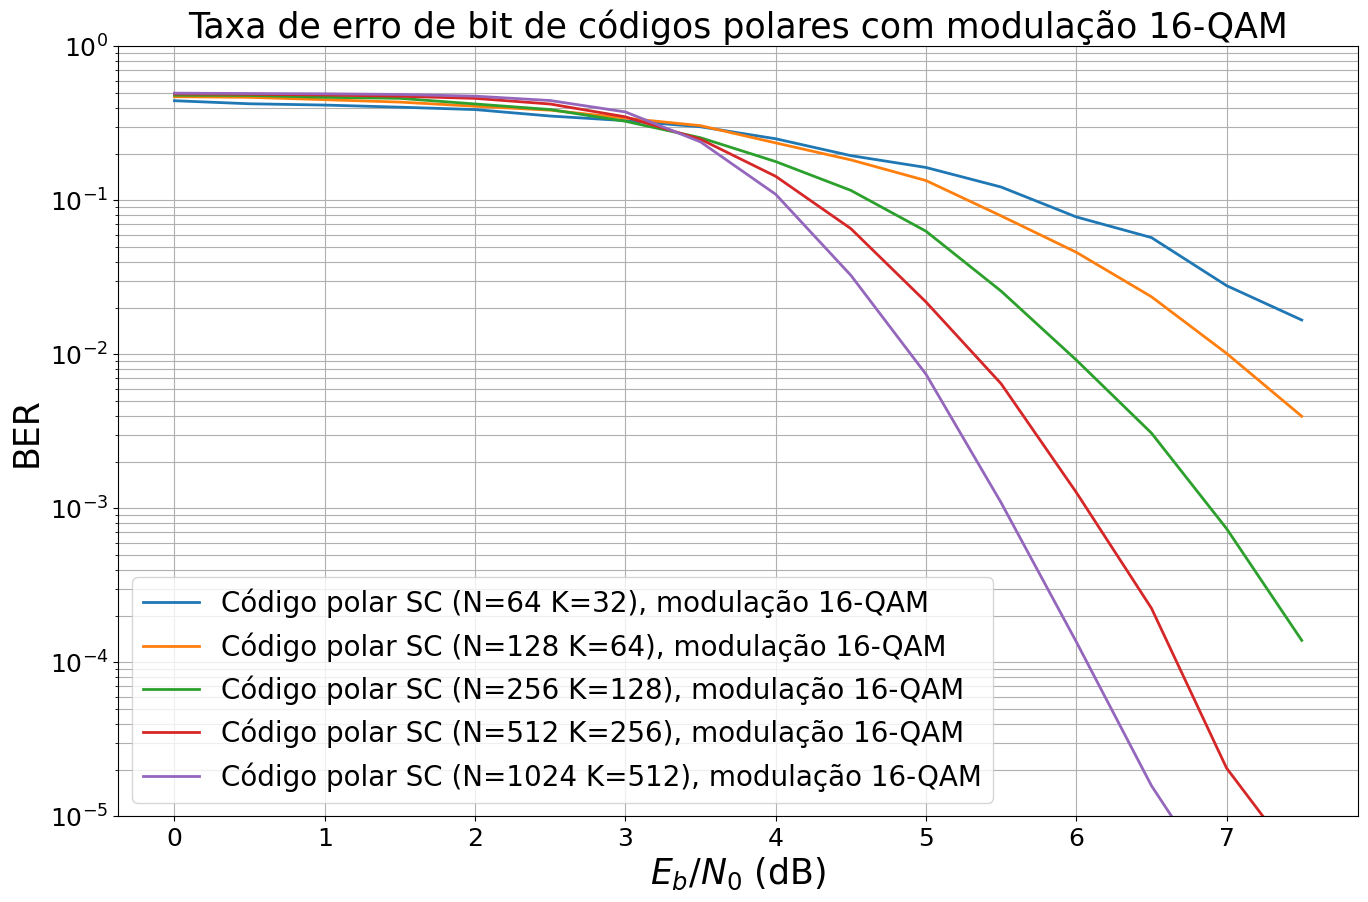

In [319]:
# e simular os resultados
num_bits_per_symbol = 4 # 16-QAM

ebno_db = np.arange(0, 11, 0.5) # intervalo de SNR para simulação
# note que a curva de queda para códigos longos pode ser íngreme e requer uma quantização fina de SNR

# executar simulações de BER para cada caso
for code in codes_under_test:
    print("Executando: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # o primeiro argumento deve ser uma função que gera u e u_hat
    # para um dado batch_size e ebno
    # fixamos o número alvo de erros de BLOCO em vez do BER para
    # garantir que os mesmos resultados precisos para cada comprimento de bloco sejam simulados
    ber_plot_Polar.simulate(model, # a função definida anteriormente
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # fixamos os erros de bloco alvo
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # deve ser True em um loop

# e mostrar a figura
ber_plot_Polar(ylim=(1e-5, 1))

## 256-QAM: 8 bits por símbolo

In [320]:
# inicia uma nova figura
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 256-QAM")

In [321]:
# parâmetros do código para simulação
ns = [64,128,256,512,1024]  # número de bits por palavra-código
rate = 0.5 # taxa de código fixa

# criar lista de pares codificador/decodificador a serem analisados
codes_under_test = []

# códigos Polares 5G
for n in ns:
    k = int(rate*n) # calcular k para o dado n e taxa
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name = f"Código polar SC (N={n} K={k}), modulação 256-QAM"
    codes_under_test.append([enc, dec, name, k, n])

Executando: Código polar SC (N=64 K=32), modulação 256-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.8453e-01 | 1.0000e+00 |       15505 |       32000 |         1000 |        1000 |         6.0 |reached target block errors
      0.5 | 4.8306e-01 | 1.0000e+00 |       15458 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      1.0 | 4.8306e-01 | 1.0000e+00 |       15458 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      1.5 | 4.7381e-01 | 1.0000e+00 |       15162 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      2.0 | 4.6959e-01 | 1.0000e+00 |       15027 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      

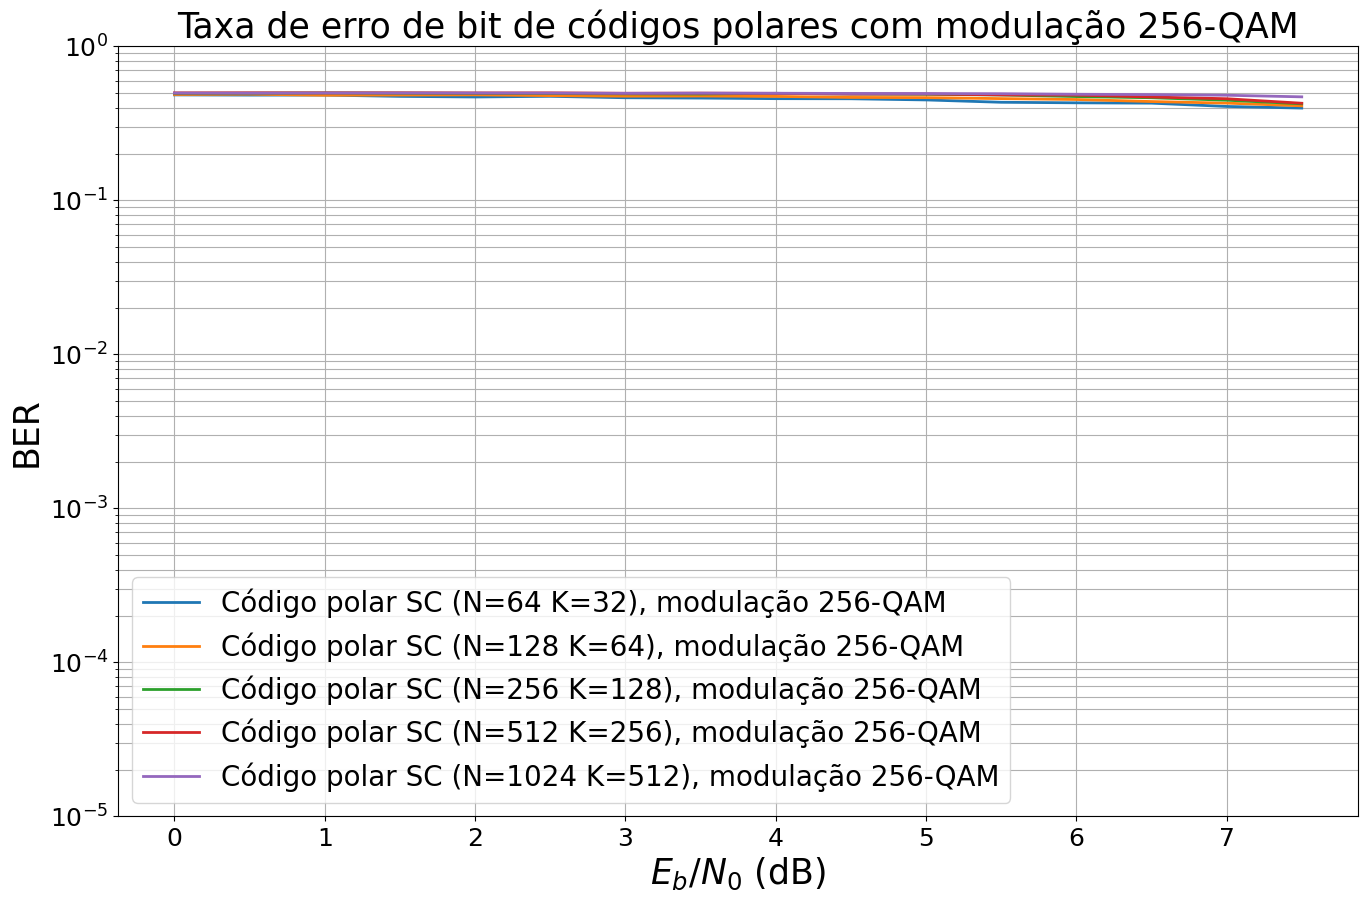

In [322]:
# e simular os resultados
num_bits_per_symbol = 8 # 256-QAM

ebno_db = np.arange(0, 11, 0.5) # intervalo de SNR para simulação
# note que a curva de queda para códigos longos pode ser íngreme e requer uma quantização fina de SNR

# executar simulações de BER para cada caso
for code in codes_under_test:
    print("Executando: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # o primeiro argumento deve ser uma função que gera u e u_hat
    # para um dado batch_size e ebno
    # fixamos o número alvo de erros de BLOCO em vez do BER para
    # garantir que os mesmos resultados precisos para cada comprimento de bloco sejam simulados
    ber_plot_Polar.simulate(model, # a função definida anteriormente
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # fixamos os erros de bloco alvo
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # deve ser True em um loop

# e mostrar a figura
ber_plot_Polar(ylim=(1e-5, 1))

# teste com não codificada

In [80]:
class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=0.5)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

In [81]:
model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=4, block_length=1024)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.1050e-01 | 1.0000e+00 |       21555 |      102400 |          100 |         100 |         0.1 |reached target block errors
    0.526 | 1.9871e-01 | 1.0000e+00 |       20348 |      102400 |          100 |         100 |         0.1 |reached target block errors
    1.053 | 1.8360e-01 | 1.0000e+00 |       18801 |      102400 |          100 |         100 |         0.1 |reached target block errors
    1.579 | 1.7475e-01 | 1.0000e+00 |       17894 |      102400 |          100 |         100 |         0.1 |reached target block errors
    2.105 | 1.6119e-01 | 1.0000e+00 |       16506 |      102400 |          100 |         100 |         0.1 |reached target block errors
    2.632 | 1.4790e-01 | 1.0000e+00 |       15145 |      102400 |

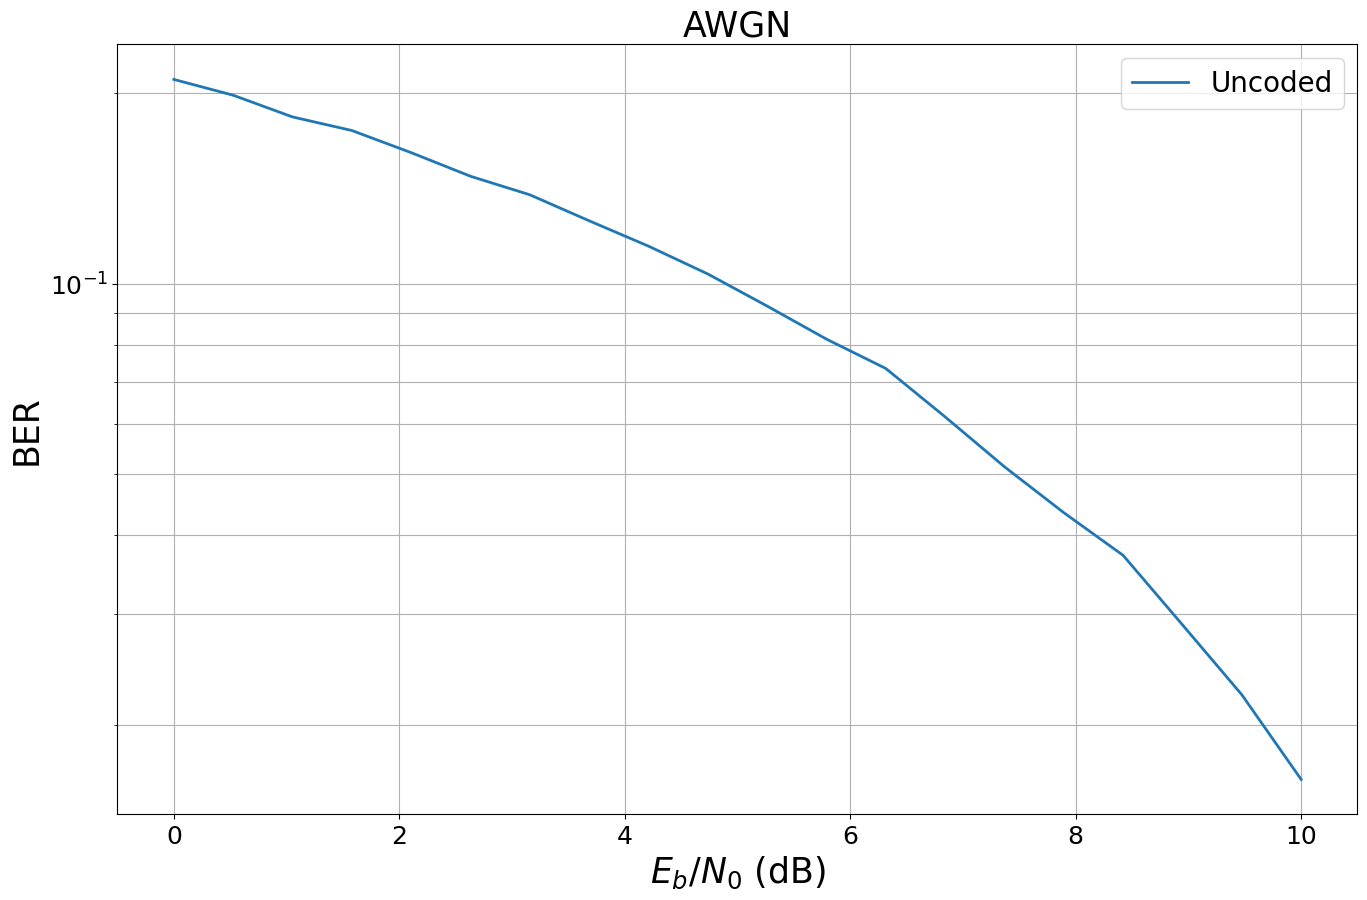

In [82]:
EBN0_DB_MIN = 0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 100 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

In [83]:
class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)

        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)

        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        # self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        # self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)
        self.encoder = sn.fec.polar.Polar5GEncoder(k, n)
        self.decoder = sn.fec.polar.Polar5GDecoder(self.encoder,dec_type="SC")

    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.6563e-01 | 1.0000e+00 |        1490 |        3200 |          100 |         100 |         0.2 |reached target block errors
    0.526 | 4.3141e-01 | 9.9000e-01 |        2761 |        6400 |          198 |         200 |         0.5 |reached target block errors
    1.053 | 4.1750e-01 | 9.9500e-01 |        2672 |        6400 |          199 |         200 |         0.7 |reached target block errors
    1.579 | 3.8859e-01 | 9.5500e-01 |        2487 |        6400 |          191 |         200 |         0.6 |reached target block errors
    2.105 | 3.8906e-01 | 9.5000e-01 |        2490 |        6400 |          190 |         200 |         0.7 |reached target block errors
    2.632 | 3.3172e-01 | 8.9000e-01 |        2123 |        6400 |

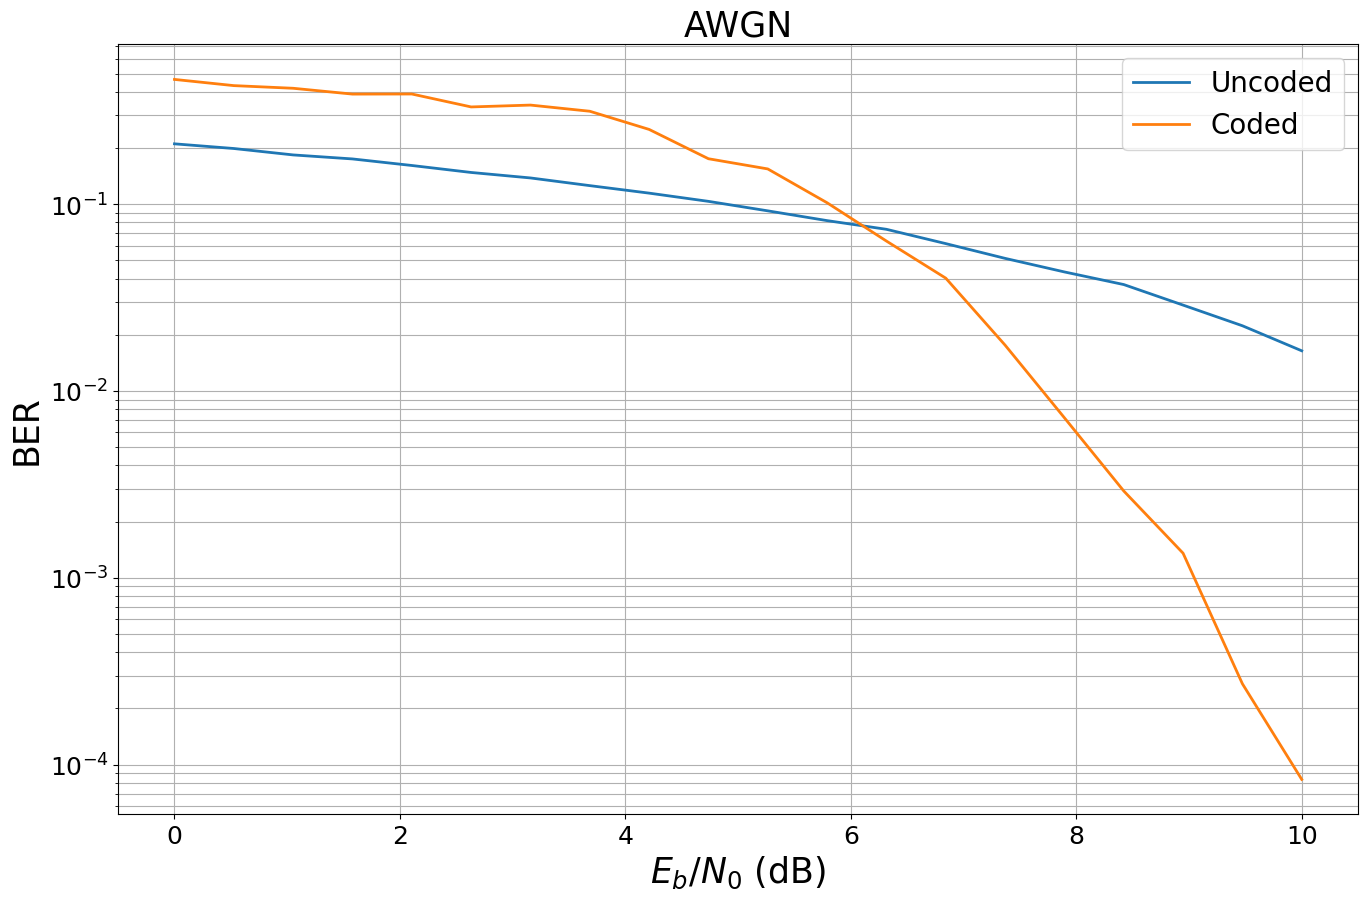

In [84]:
CODERATE = 0.5
BATCH_SIZE = 100

model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=4,
                                   n=64,
                                   coderate=CODERATE)
ber_plots.simulate(model_coded_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=100,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

# Comparação de Taxa de erro de bit para o código polar com tamanho de palavra código N=1024 K=512 utilizando modulação 4-QAM, 16-QAM e 256-QAM

In [338]:
# Inicia uma nova figura
ber_plot_Polar = PlotBER(f"Taxa de erro de bit de códigos polares com modulação 4-QAM, 16-QAM e 256-QAM")

In [339]:
# parâmetros do código para simulação
ns = [64]  # número de bits por palavra-código
rate = 0.5 # taxa de código fixa

# criar lista de pares codificador/decodificador a serem analisados
codes_under_test = []

# códigos Polares 5G
for n in ns:
    k = int(rate*n) # calcular k para o dado n e taxa
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name = f"Código polar SC (N={n} K={k}), modulação 4-QAM"
    codes_under_test.append([enc, dec, name, k, n])


Executando: Código polar SC (N=64 K=32), modulação 4-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.9337e-01 | 9.4700e-01 |       12588 |       32000 |          947 |        1000 |         5.0 |reached target block errors
      0.5 | 3.5644e-01 | 8.8600e-01 |       11406 |       32000 |          886 |        1000 |         0.0 |reached target block errors
      1.0 | 3.1519e-01 | 8.1100e-01 |       10086 |       32000 |          811 |        1000 |         0.0 |reached target block errors
      1.5 | 2.6928e-01 | 7.4000e-01 |        8617 |       32000 |          740 |        1000 |         0.0 |reached target block errors
      2.0 | 2.0969e-01 | 5.9200e-01 |        6710 |       32000 |          592 |        1000 |         0.0 |reached target block errors
      2.

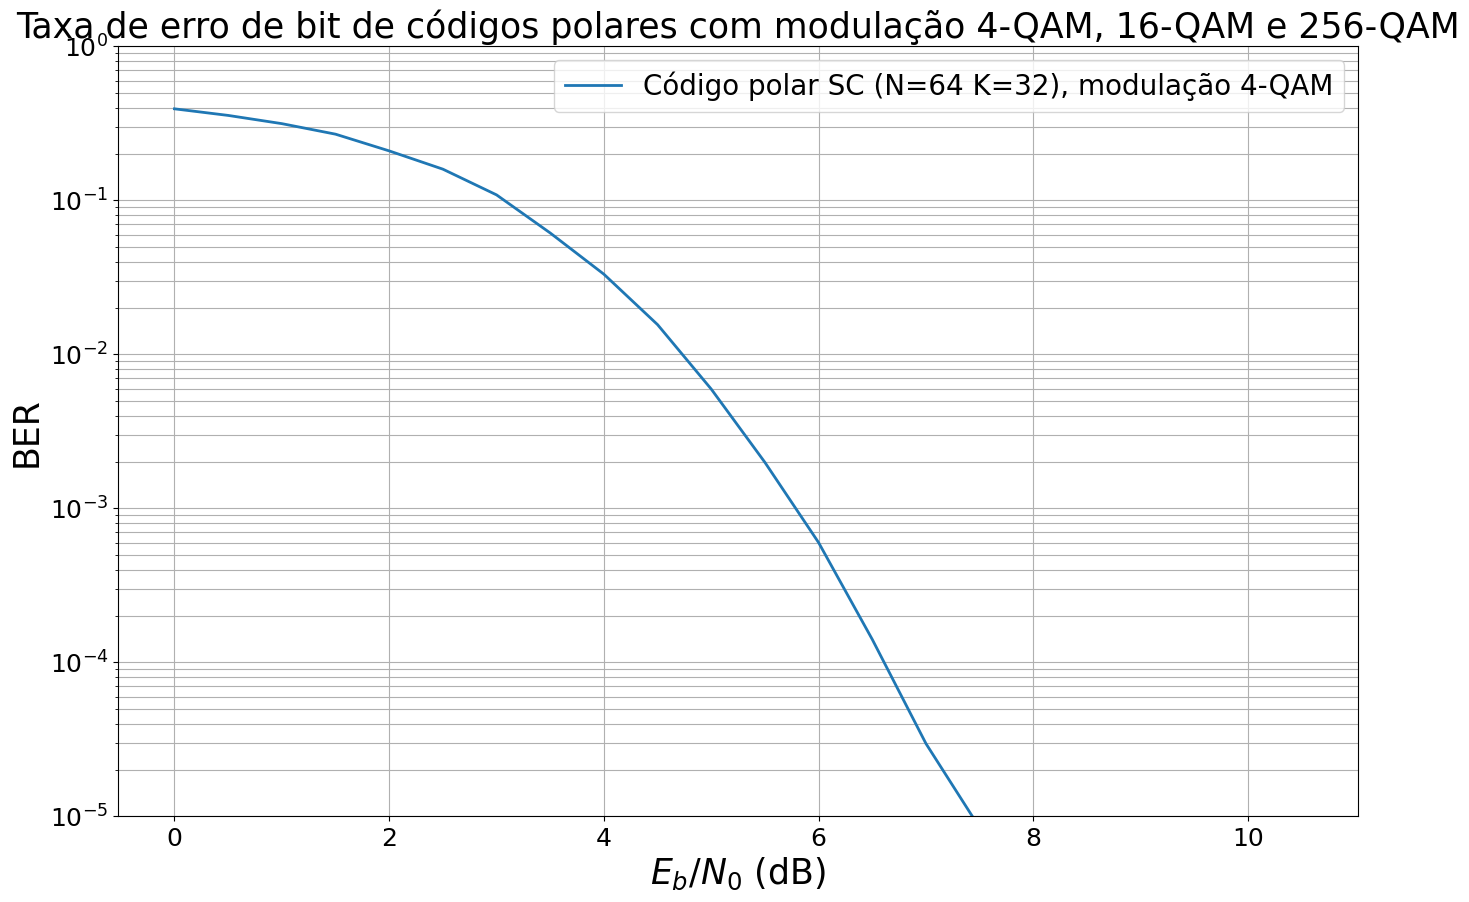

In [340]:
# e simular os resultados
num_bits_per_symbol = 2 # QPSK = 4-QAM

ebno_db = np.arange(0, 11, 0.5) # intervalo de SNR para simulação
# note que a curva de queda para códigos longos pode ser íngreme e requer uma quantização fina de SNR

# executar simulações de BER para cada caso
for code in codes_under_test:
    print("Executando: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # o primeiro argumento deve ser uma função que gera u e u_hat
    # para um dado batch_size e ebno
    # fixamos o número alvo de erros de BLOCO em vez do BER para
    # garantir que os mesmos resultados precisos para cada comprimento de bloco sejam simulados
    ber_plot_Polar.simulate(model, # a função definida anteriormente
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # fixamos os erros de bloco alvo
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # deve ser True em um loop

# e mostrar a figura
ber_plot_Polar(ylim=(1e-5, 1))

In [341]:
# parâmetros do código para simulação
ns = [64]  # número de bits por palavra-código
rate = 0.5 # taxa de código fixa

# criar lista de pares codificador/decodificador a serem analisados
codes_under_test = []

# códigos Polares 5G
for n in ns:
    k = int(rate*n) # calcular k para o dado n e taxa
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name = f"Código polar SC (N={n} K={k}), modulação 16-QAM"
    codes_under_test.append([enc, dec, name, k, n])

Executando: Código polar SC (N=64 K=32), modulação 16-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.4431e-01 | 9.9200e-01 |       14218 |       32000 |          992 |        1000 |        12.7 |reached target block errors
      0.5 | 4.3928e-01 | 9.9600e-01 |       14057 |       32000 |          996 |        1000 |         0.1 |reached target block errors
      1.0 | 4.1787e-01 | 9.8000e-01 |       13372 |       32000 |          980 |        1000 |         0.1 |reached target block errors
      1.5 | 4.1200e-01 | 9.6900e-01 |       13184 |       32000 |          969 |        1000 |         0.1 |reached target block errors
      2.0 | 3.8416e-01 | 9.4500e-01 |       12293 |       32000 |          945 |        1000 |         0.1 |reached target block errors
      2

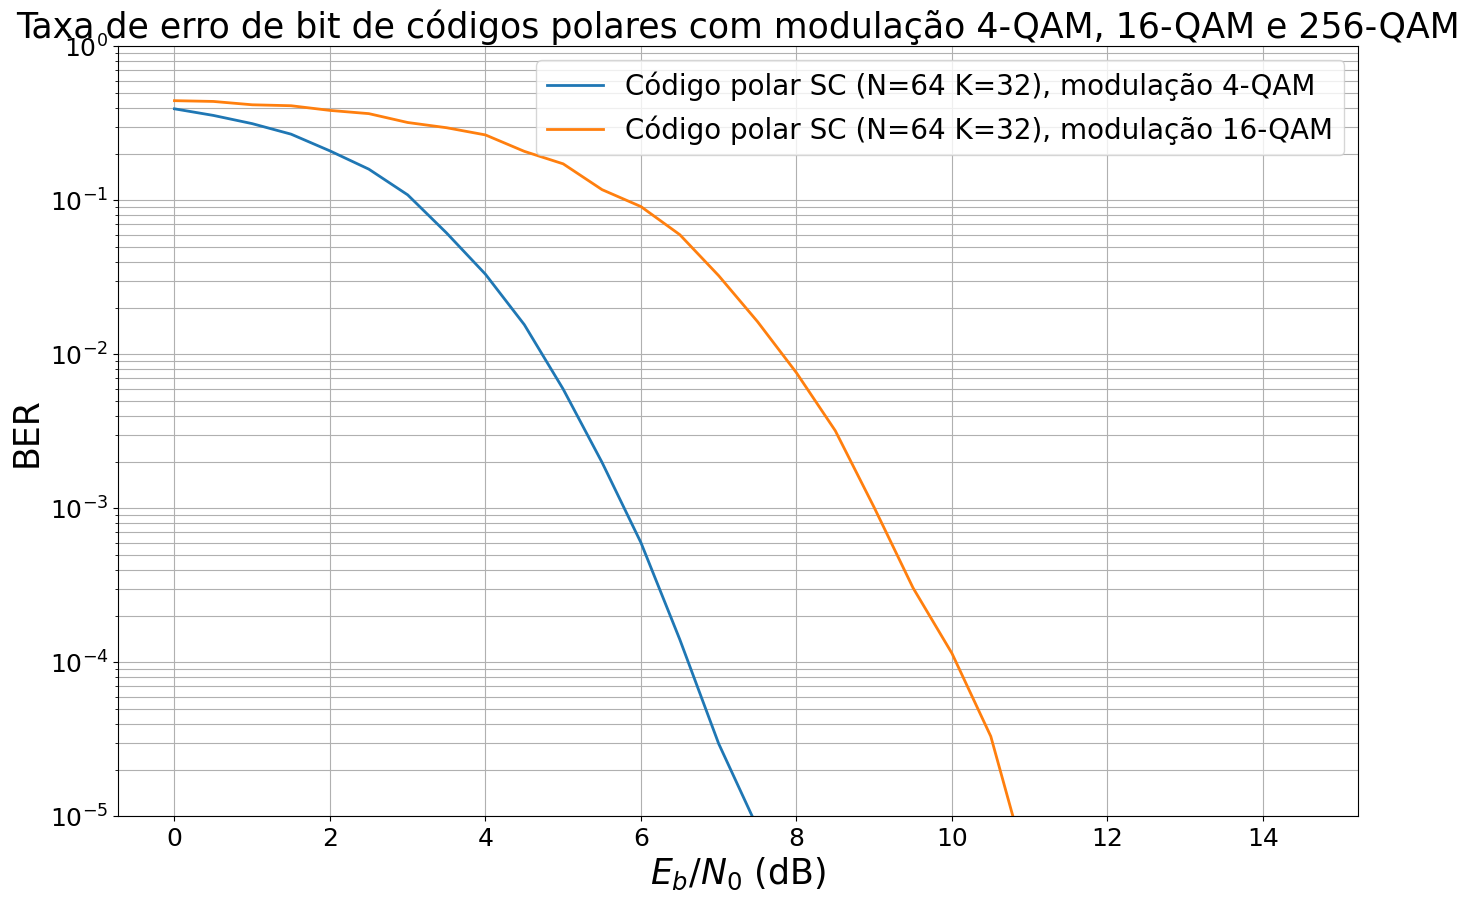

In [342]:
# e simular os resultados
num_bits_per_symbol = 4 # 16-QAM

ebno_db = np.arange(0, 15, 0.5) # intervalo de SNR para simulação
# note que a curva de queda para códigos longos pode ser íngreme e requer uma quantização fina de SNR

# executar simulações de BER para cada caso
for code in codes_under_test:
    print("Executando: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # o primeiro argumento deve ser uma função que gera u e u_hat
    # para um dado batch_size e ebno
    # fixamos o número alvo de erros de BLOCO em vez do BER para
    # garantir que os mesmos resultados precisos para cada comprimento de bloco sejam simulados
    ber_plot_Polar.simulate(model, # a função definida anteriormente
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # fixamos os erros de bloco alvo
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # deve ser True em um loop

# e mostrar a figura
ber_plot_Polar(ylim=(1e-5, 1))

In [343]:
# parâmetros do código para simulação
ns = [64]  # número de bits por palavra-código
rate = 0.5 # taxa de código fixa

# criar lista de pares codificador/decodificador a serem analisados
codes_under_test = []

# códigos Polares 5G
for n in ns:
    k = int(rate*n) # calcular k para o dado n e taxa
    enc = Polar5GEncoder(k=k, n=n)
    dec = Polar5GDecoder(enc, num_iter=20)
    name = f"Código polar SC (N={n} K={k}), modulação 256-QAM"
    codes_under_test.append([enc, dec, name, k, n])

Executando: Código polar SC (N=64 K=32), modulação 256-QAM
EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 4.8197e-01 | 1.0000e+00 |       15423 |       32000 |         1000 |        1000 |         6.2 |reached target block errors
      0.5 | 4.8681e-01 | 1.0000e+00 |       15578 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      1.0 | 4.8525e-01 | 1.0000e+00 |       15528 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      1.5 | 4.7347e-01 | 1.0000e+00 |       15151 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      2.0 | 4.7956e-01 | 1.0000e+00 |       15346 |       32000 |         1000 |        1000 |         0.3 |reached target block errors
      

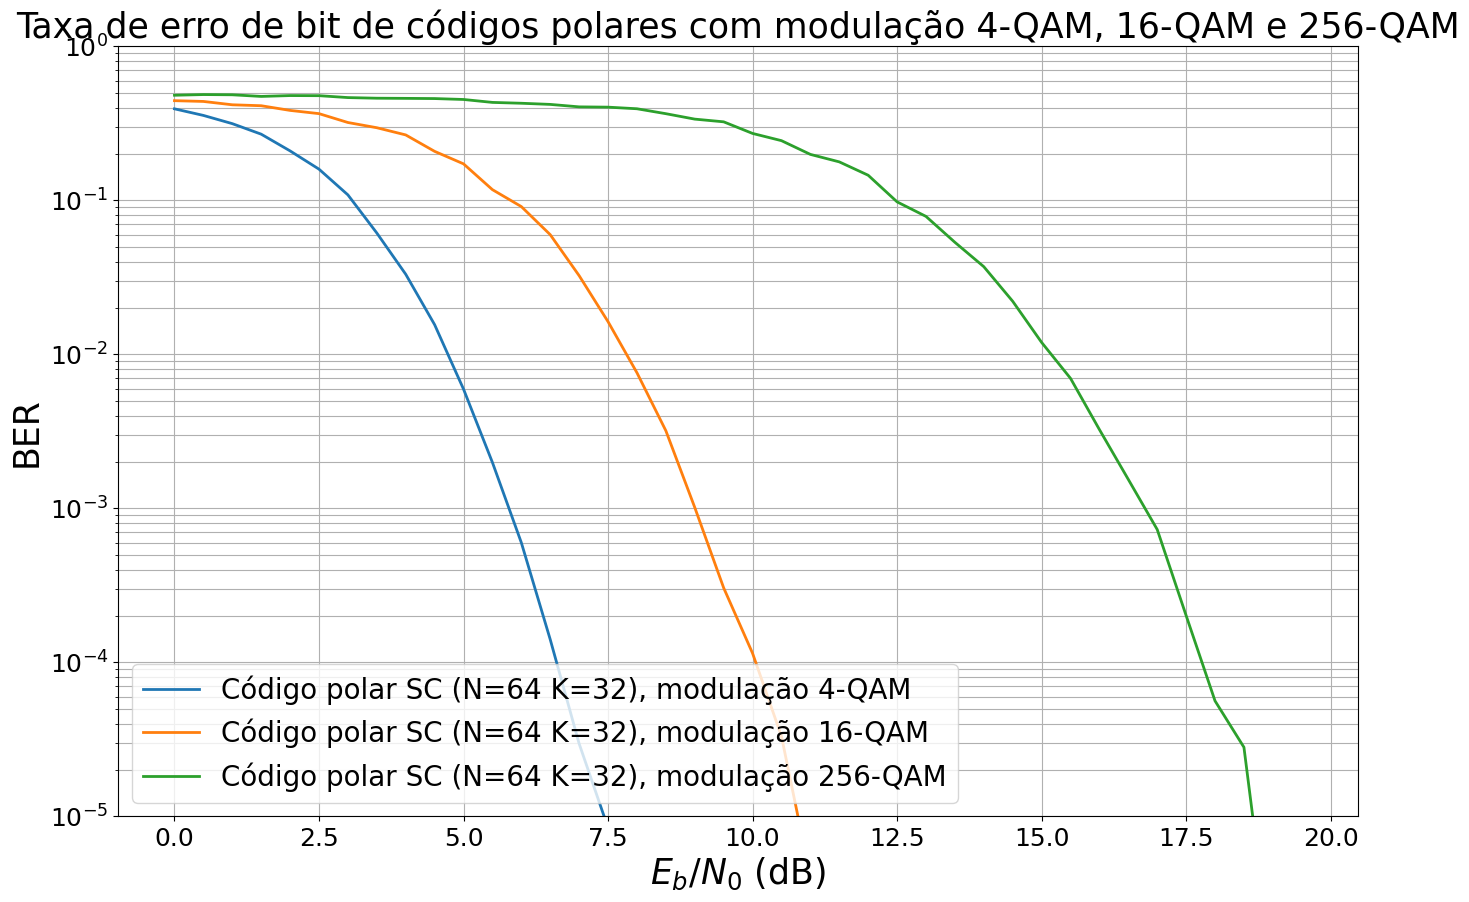

In [344]:
# e simular os resultados
num_bits_per_symbol = 8 # 256-QAM

ebno_db = np.arange(0, 20, 0.5) # intervalo de SNR para simulação
# note que a curva de queda para códigos longos pode ser íngreme e requer uma quantização fina de SNR

# executar simulações de BER para cada caso
for code in codes_under_test:
    print("Executando: " + code[2])
    model = System_Model(k=code[3],
                         n=code[4],
                         num_bits_per_symbol=num_bits_per_symbol,
                         encoder=code[0],
                         decoder=code[1])

    # o primeiro argumento deve ser uma função que gera u e u_hat
    # para um dado batch_size e ebno
    # fixamos o número alvo de erros de BLOCO em vez do BER para
    # garantir que os mesmos resultados precisos para cada comprimento de bloco sejam simulados
    ber_plot_Polar.simulate(model, # a função definida anteriormente
                           ebno_dbs=ebno_db,
                           legend=code[2],
                           max_mc_iter=100,
                           num_target_block_errors=500, # fixamos os erros de bloco alvo
                           batch_size=1000,
                           soft_estimates=False,
                           early_stop=True,
                           show_fig=False,
                           forward_keyboard_interrupt=True); # deve ser True em um loop

# e mostrar a figura
ber_plot_Polar(ylim=(1e-5, 1))